# InfoMap and InfoFlow algorithm demo

This notebook provides a demo on the InfoMap and InfoFlow algorithm. Specifically, to run the algorithms on a graph example with explanations

## Set up environment and run InfoMap

In [1]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

In [2]:
# parameters related to Java
java_conf = {
    "dir": r'/home/felix/Work/Community Detection/InfoFlow',
    "jar_name": "infoflow",
    "scala_version": "2.11",
    "infoflow_version": "0.2.6"
}

In [3]:
# parameters required in InfoFlow config file
infoflow_config = {
    "Graph": 'Nets/rosvall.net',
    "spark configs": {
        "Master": "local[*]",
        "num executors": "1",
        "executor cores": "8",
        "driver memory": "60G",
        "executor memory": "60G"
    },
    "PageRank": {
        "tele": 0.15,
        "error threshold factor": 20
    },
    "Community Detection": {
        "name": "InfoFlow",
        "merge direction": "symmetric",
        "merge nonedge": False
    },
    "log": {
        "log path": "Output/log.txt",
        "Parquet path": '',
        "RDD path": '',
        "txt path": "Output/vertex.txt",
        "Full Json path": "Output/full_graph.json",
        "Reduced Json path": "Output/reduced_graph.json",
       "debug": True
    }
}

In [4]:
def chDir( java_conf ):
    """Change to InfoFlow directory"""
    if not os.path.exists( java_conf['dir'] ):
        raise RuntimeError("Working directory {} does not exist".format(java_conf['dir']))

    os.chdir( java_conf['dir'] )

    if os.getcwd() != java_conf['dir'] and os.getcwd()+'/' != java_conf.infoflow_dir:
        raise RuntimeError("Working directory {} does not exist".format(java_conf['dir']))

chDir(java_conf)

In [5]:
def runInfoFlow( java_conf, infoflow_config ):
    """Set up config file and runs InfoFlow"""

    infoflow_config_string = json.dumps( infoflow_config, indent=2 )
    notebook_json = "notebook.json"
    with open(notebook_json,"w") as config_handle:
        config_handle.write(infoflow_config_string)

    jar = "{}_{}-{}.jar".format( java_conf['jar_name'], java_conf['scala_version'], java_conf['infoflow_version'] )
    return os.system("spark-submit target/scala-{}/{} {}".format( java_conf['scala_version'], jar, "notebook.json" ))
infoflow_config['Community Detection']['name'] = 'InfoMap'
runInfoFlow( java_conf, infoflow_config )

0

In [6]:
def graph_name_idx( graph_name, idx ):
    """define this function to parse graph indices"""
    name, ext = graph_name.split('.')
    return "{}{}.{}".format( name, idx, ext )

In [7]:
def plotGraph( graph_name, idx ):
    """Plot the (idx)th graph (stored in Json format)"""
    with open( graph_name_idx( graph_name, idx ) ) as graphHandle:
        graphJS = json.load( graphHandle )
    graphData = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )

    custom_color_map = plt.get_cmap('tab20')

    sub_nodes = []
    sub_nodes_size = []
    sub_nodes_color = []
    for i in range( len(graphJS['nodes']) ):
        if( float(graphJS['nodes'][i]['id']) > 0 ):
            sub_nodes.append( graphJS['nodes'][i]['id'] )
            sub_nodes_size.append(float( graphJS['nodes'][i]['size'] ) *3000)
            sub_nodes_color.append( custom_color_map( \
                float(int(graphJS['nodes'][i]['group'])%11)/11 ) )

    filteredGraph = graphData.subgraph( sub_nodes )

    plt.figure( figsize=[20,10], clear=True )
    nx.draw_networkx_nodes( filteredGraph, pos=nx.spectral_layout(filteredGraph), nodelist=filteredGraph.nodes, \
                           node_size=sub_nodes_size, \
                           alpha=0.5, node_color=sub_nodes_color )
    nx.draw_networkx_labels( filteredGraph, pos=nx.spectral_layout(filteredGraph), nodelist=filteredGraph.nodes )
    nx.draw_networkx_edges( filteredGraph, pos=nx.spectral_layout(filteredGraph), edgelist=filteredGraph.edges, alpha=0.2 )
    plt.xticks([])
    plt.yticks([])

## Now look at the initial, full graph with 25 nodes

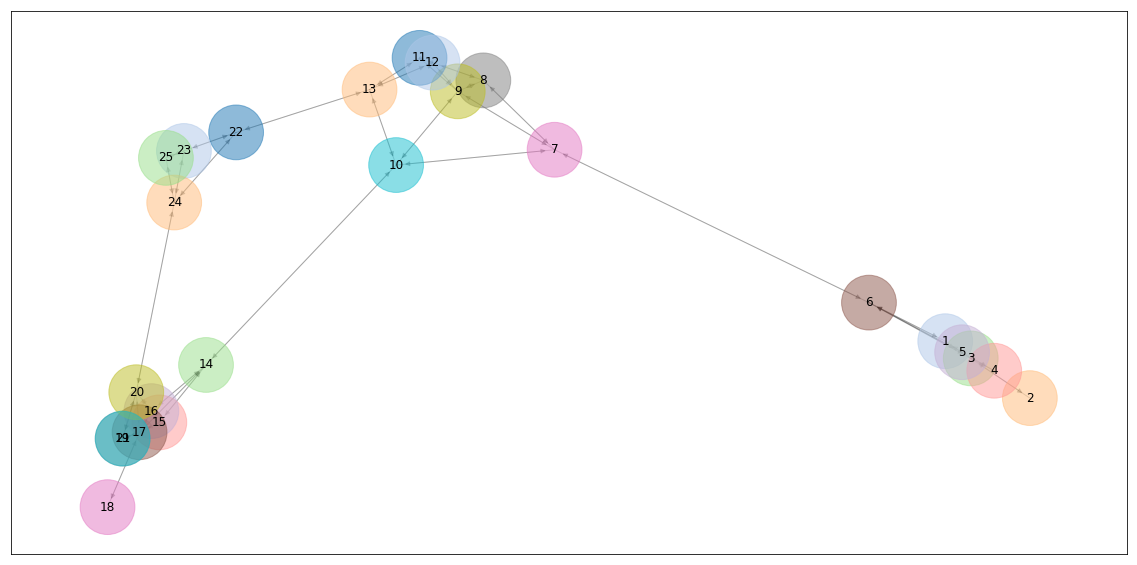

In [8]:
plotGraph( infoflow_config['log']["Full Json path"], 0 )

InfoMap is a greedy algorithm where we try to minimize entropy by forming communities. More concretely, in each iteration, we merge the pair of communities that would offer the greatest reduction in entropy; the algorithm terminates when no such pairs exist.

In this concrete example, in the first iteration, we merge nodes 23 and 24; observe that their colours are now the same, indicating they are in the same community

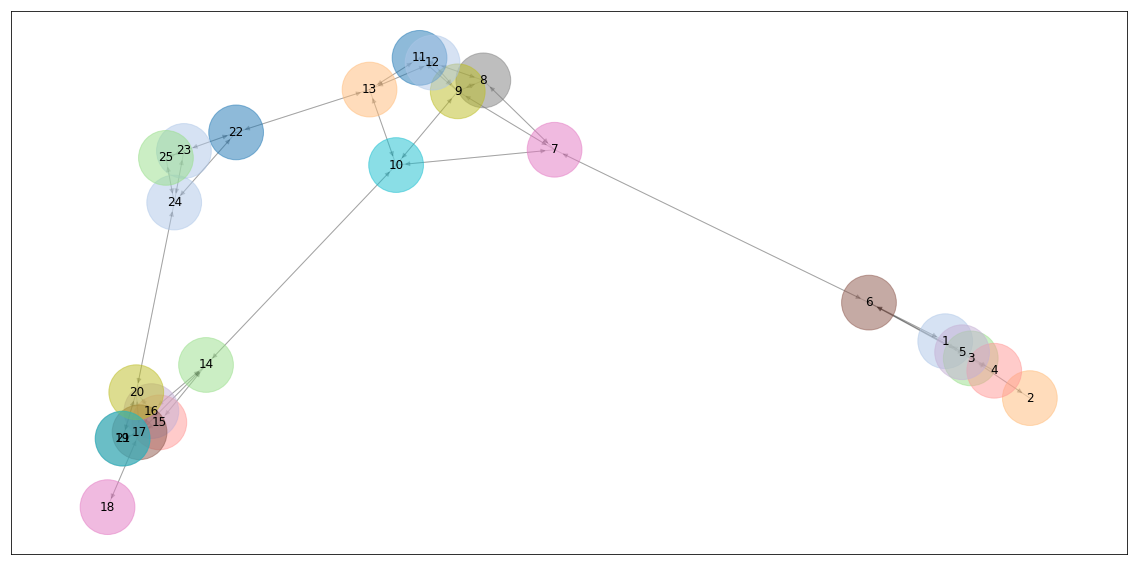

In [9]:
plotGraph( infoflow_config['log']["Full Json path"], 1 )

Now see the rest of InfoMap iterations, where within each iteration, a pair of communities merge; each community is shown with the same colour; in the end there are four communities left, not bad

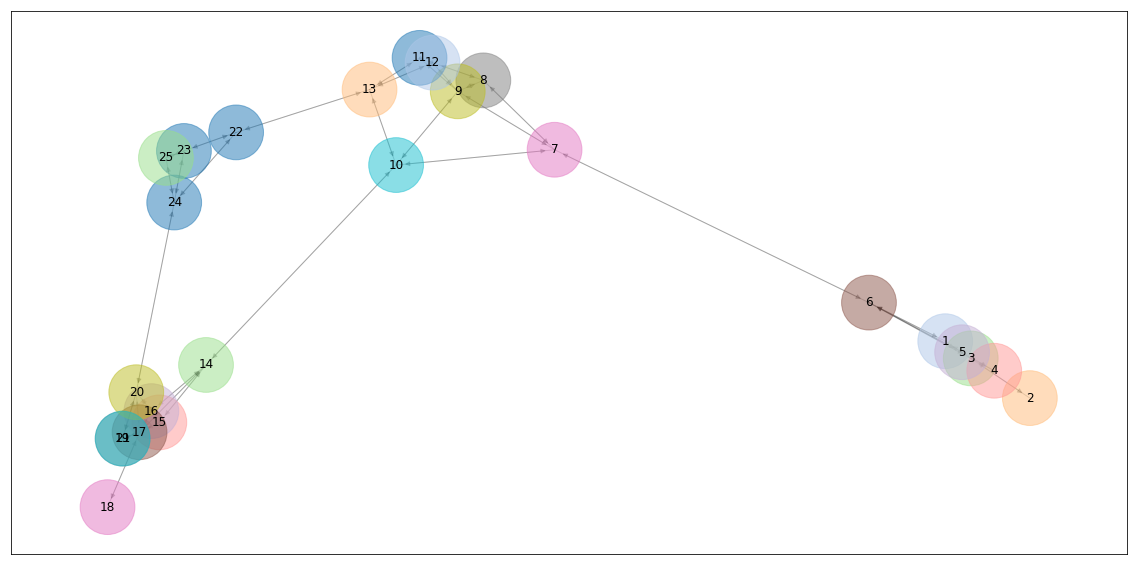

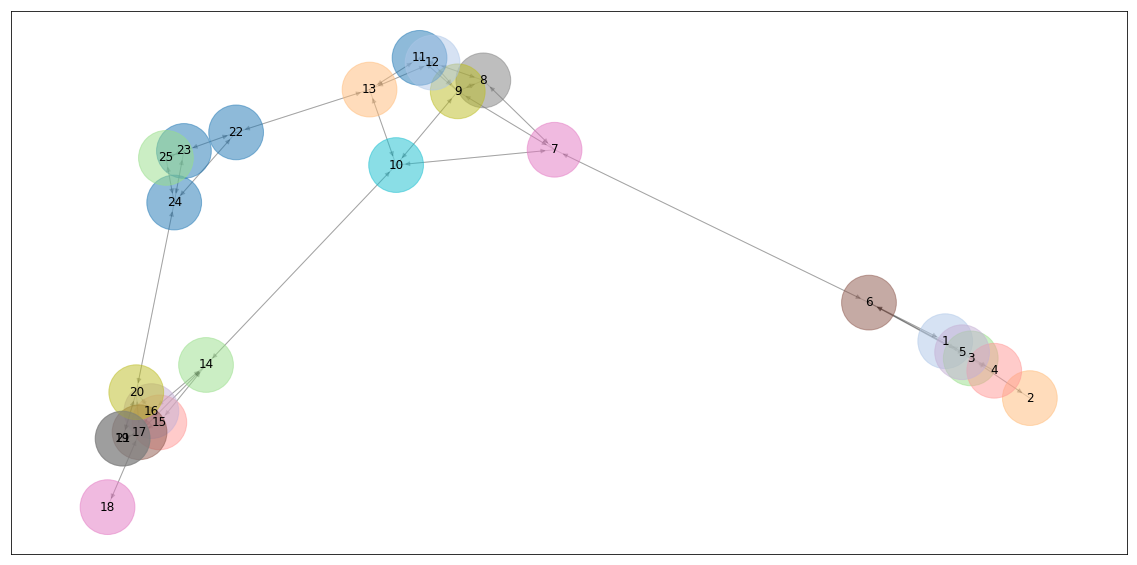

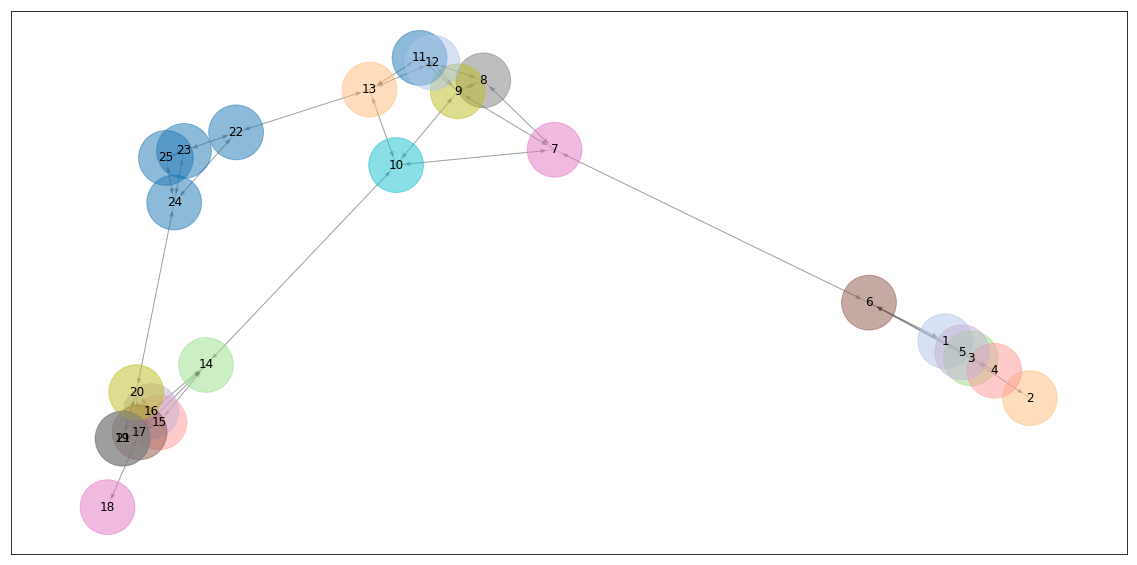

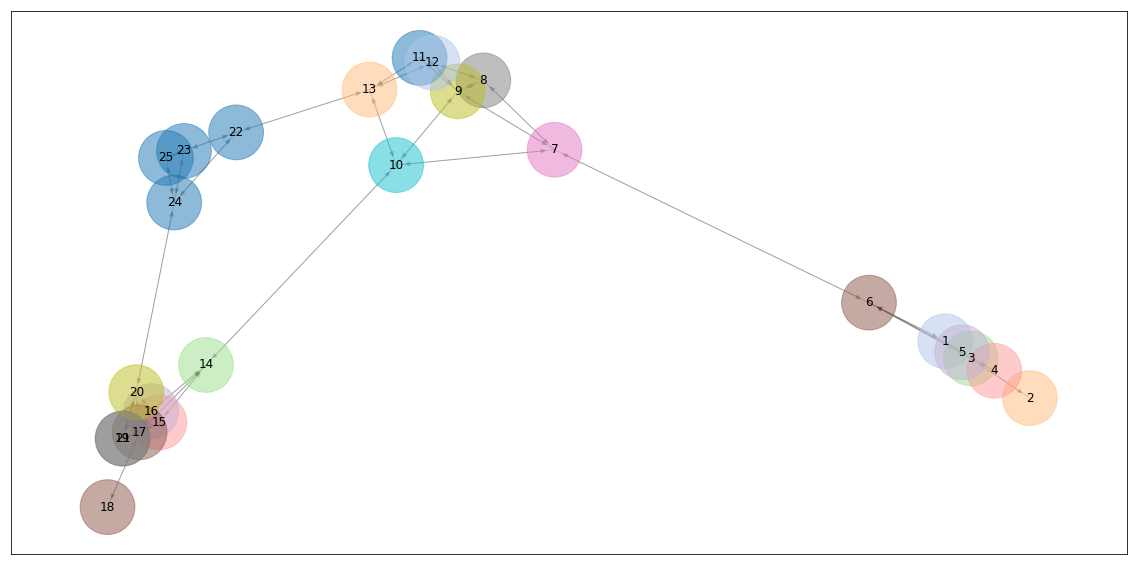

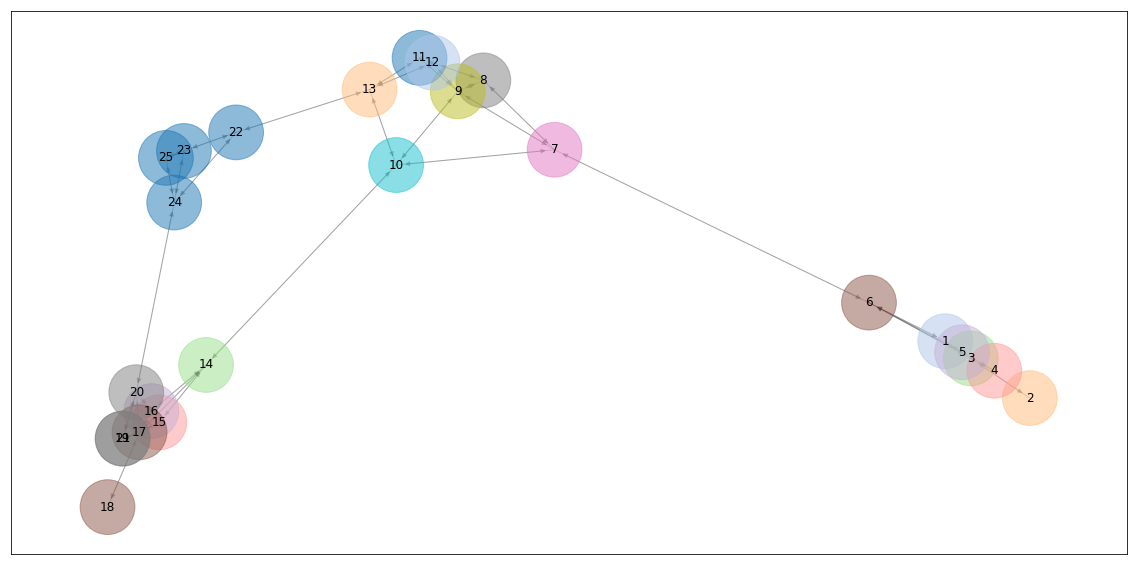

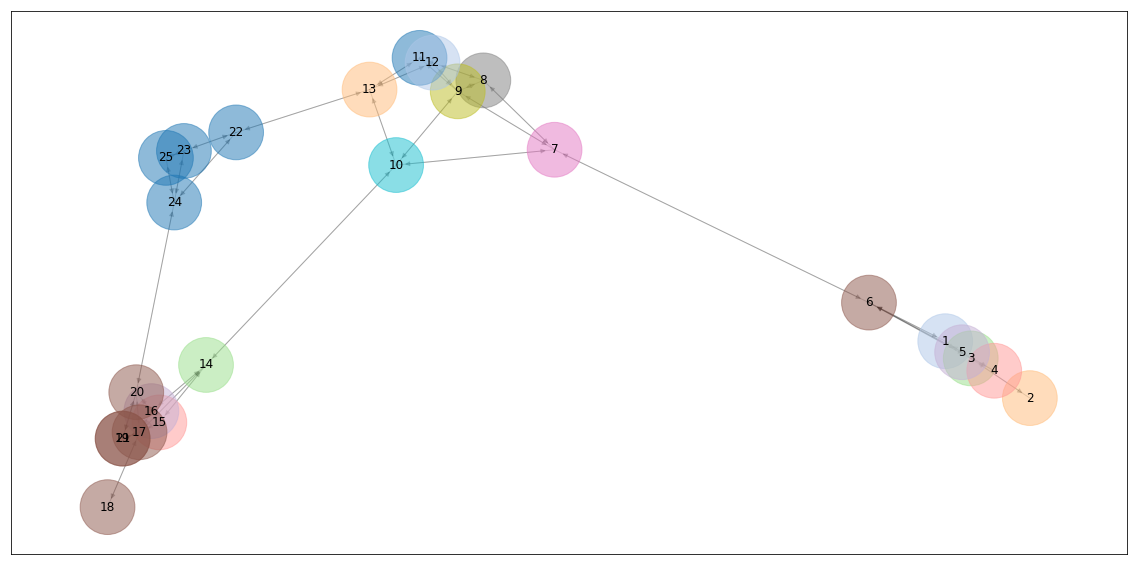

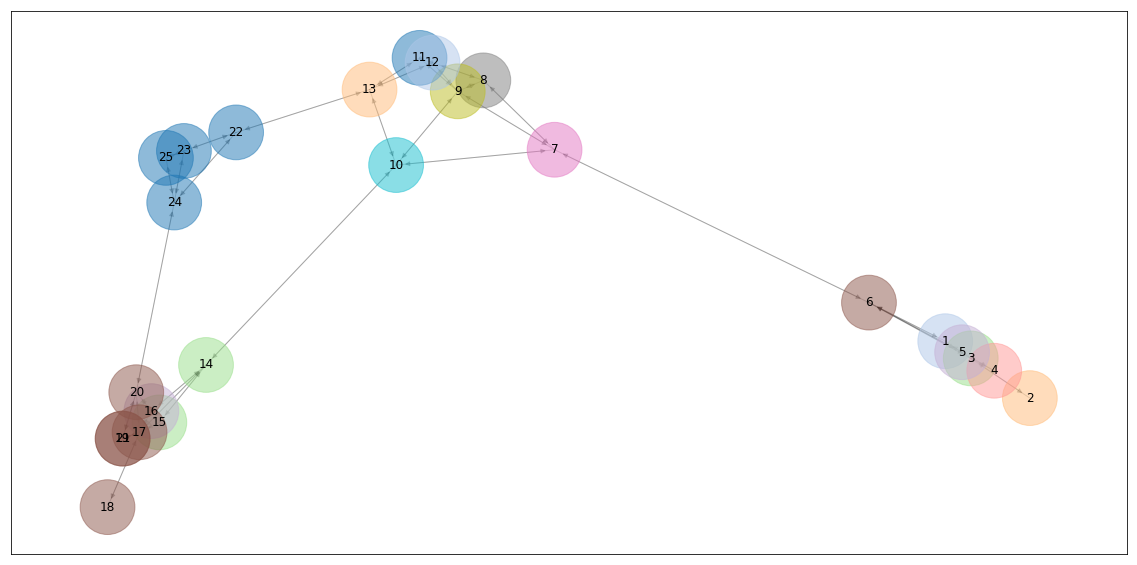

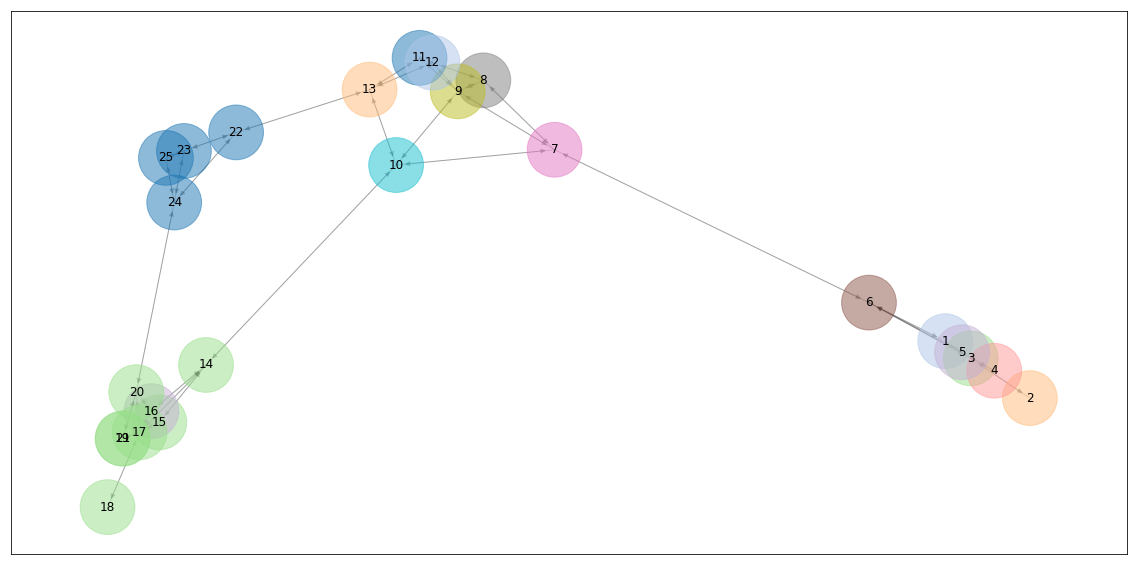

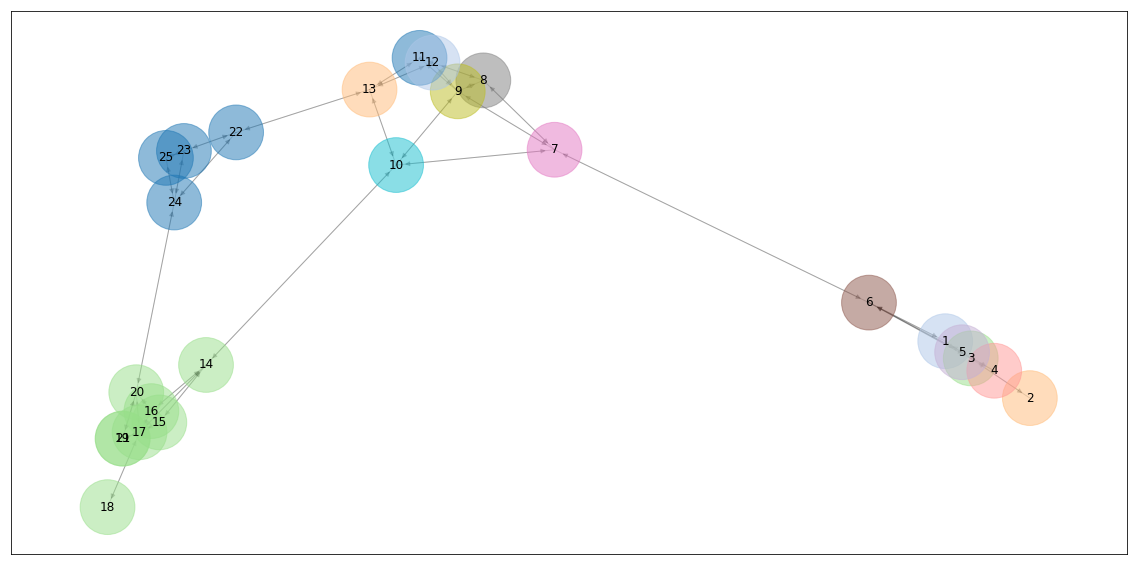

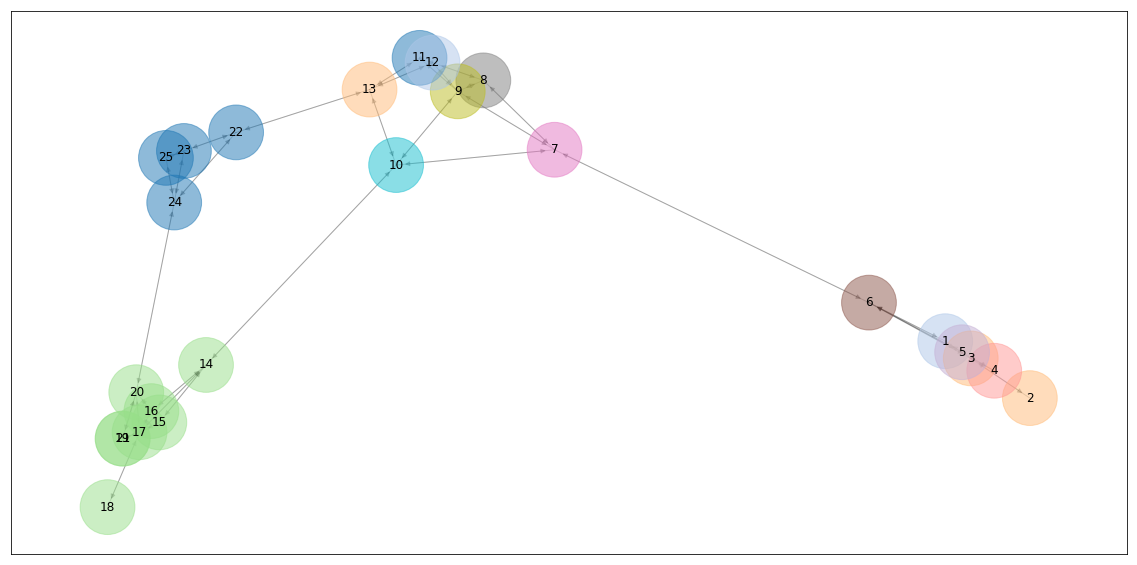

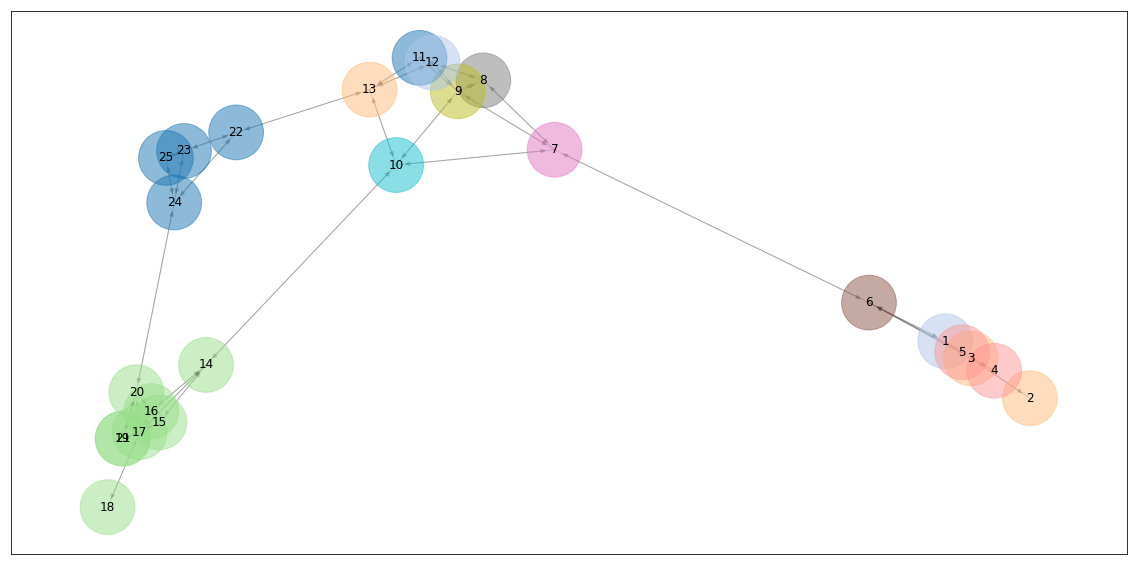

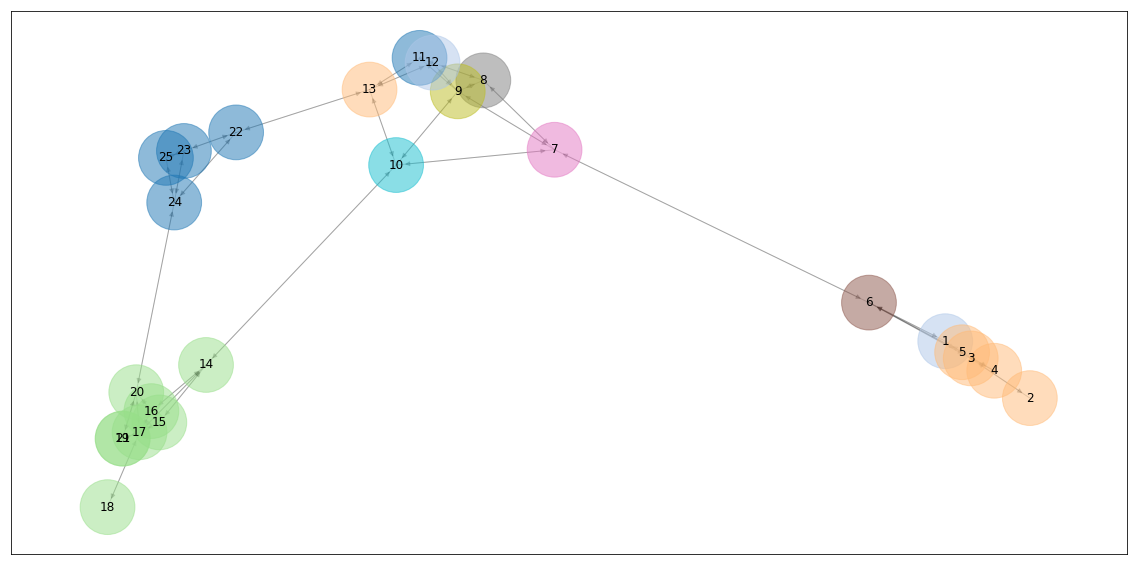

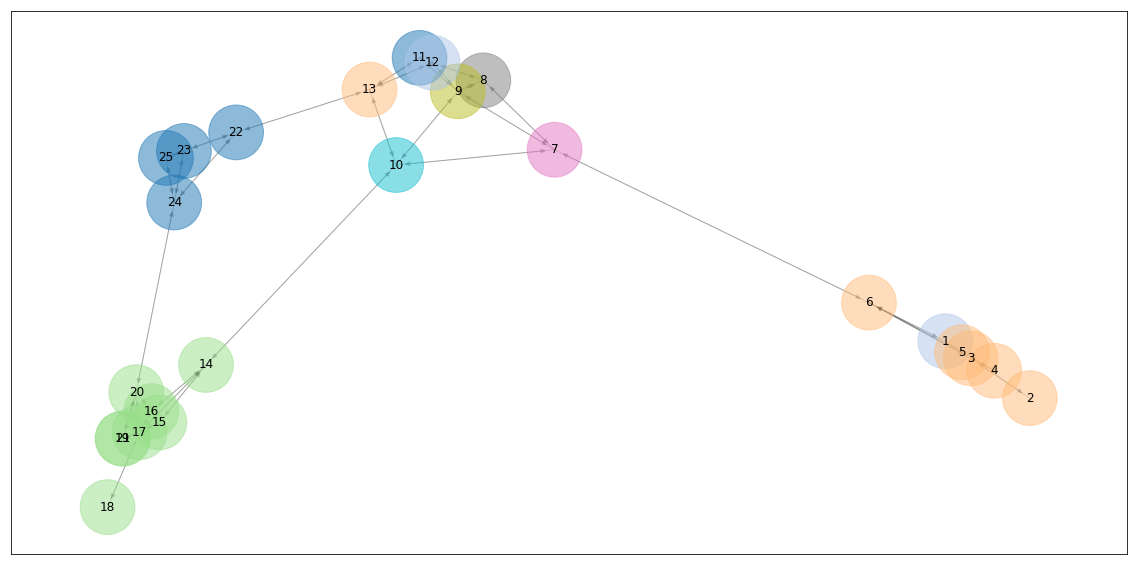

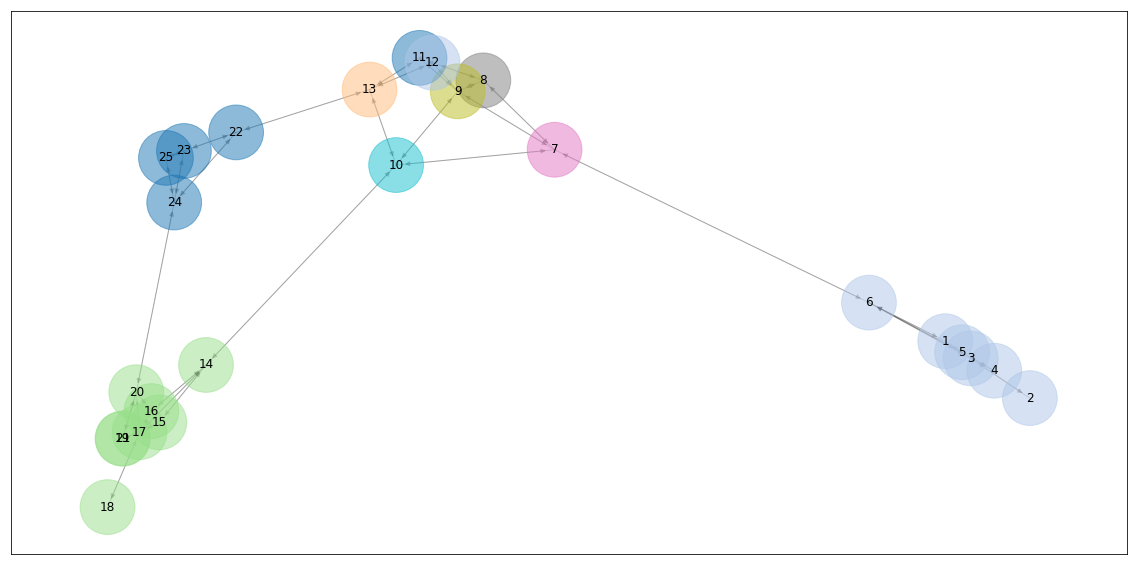

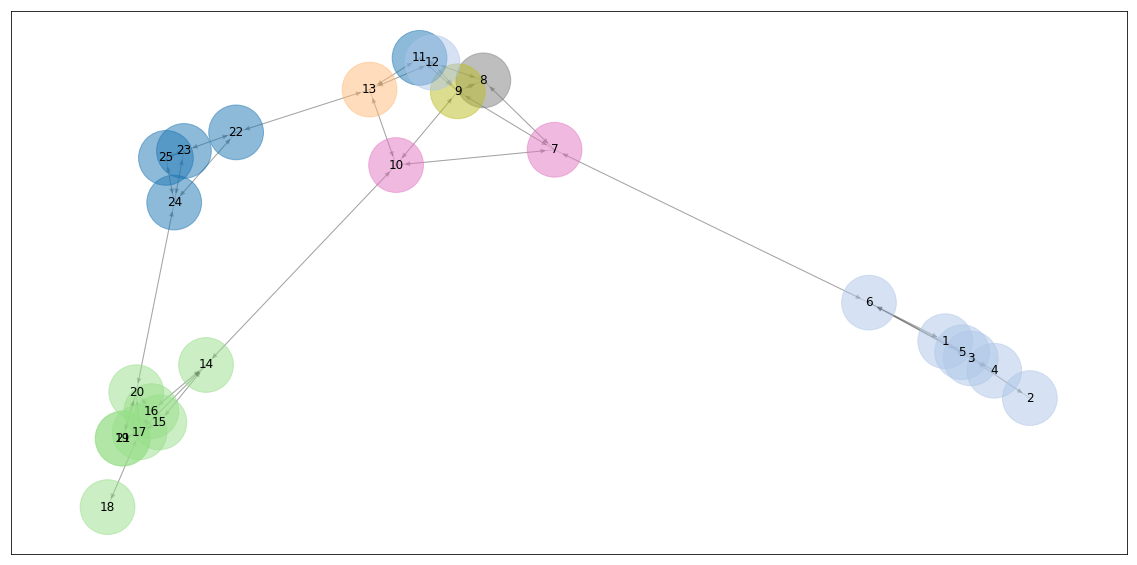

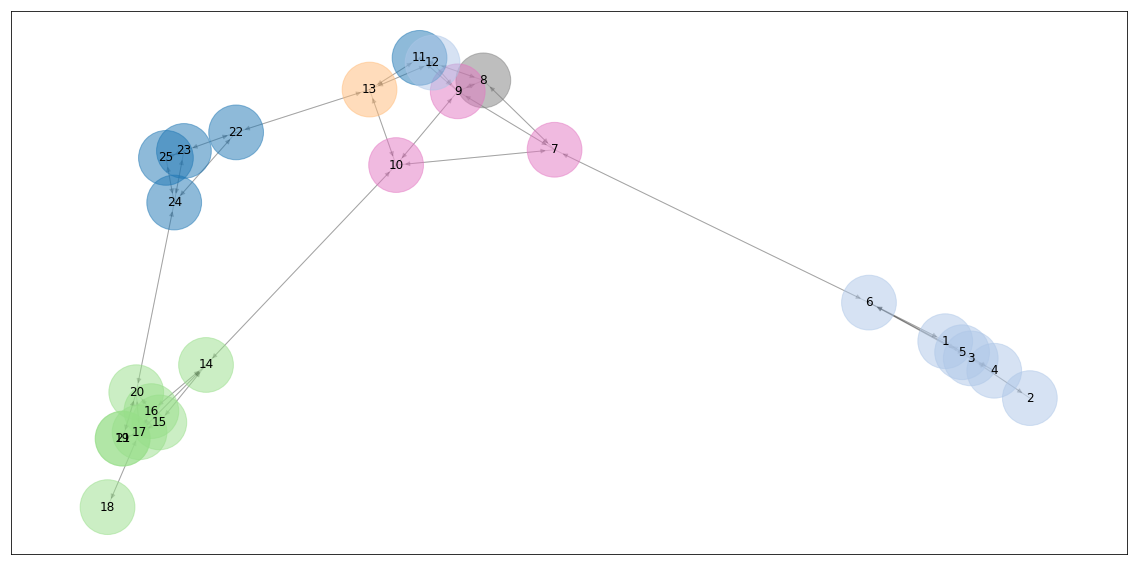

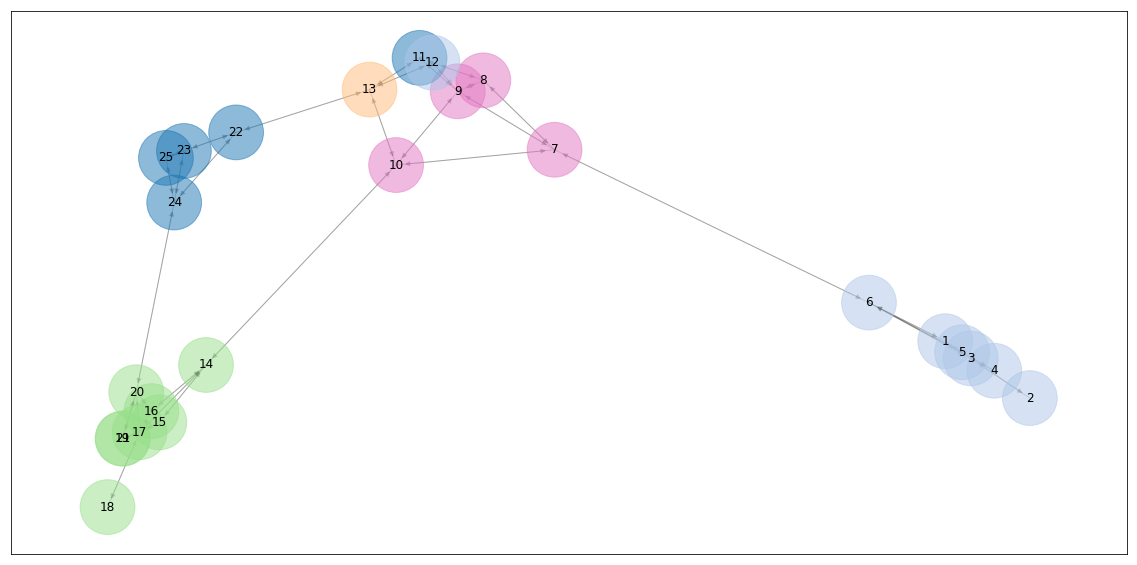

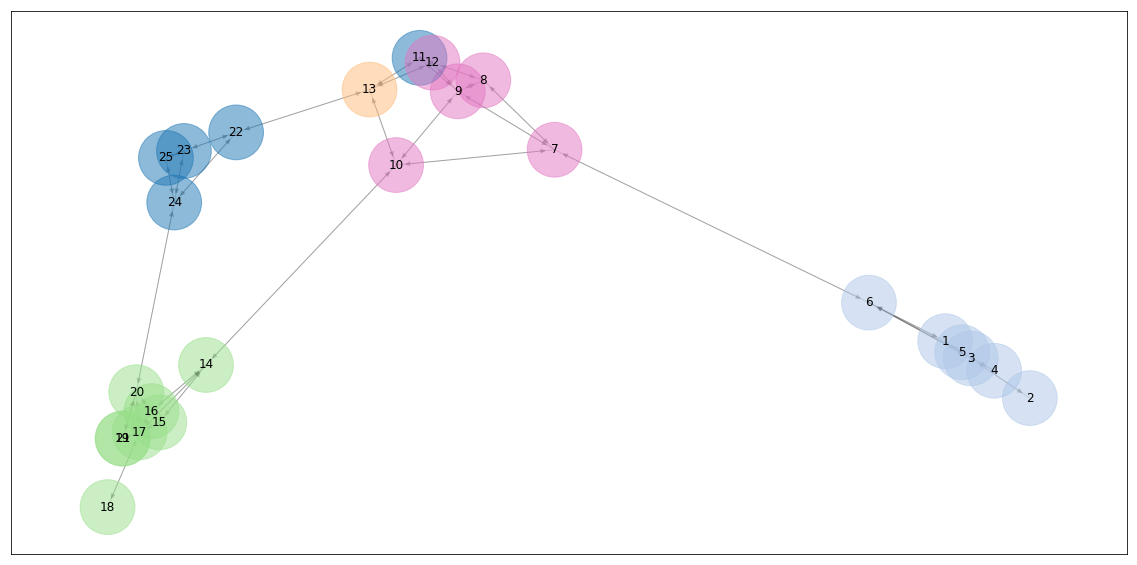

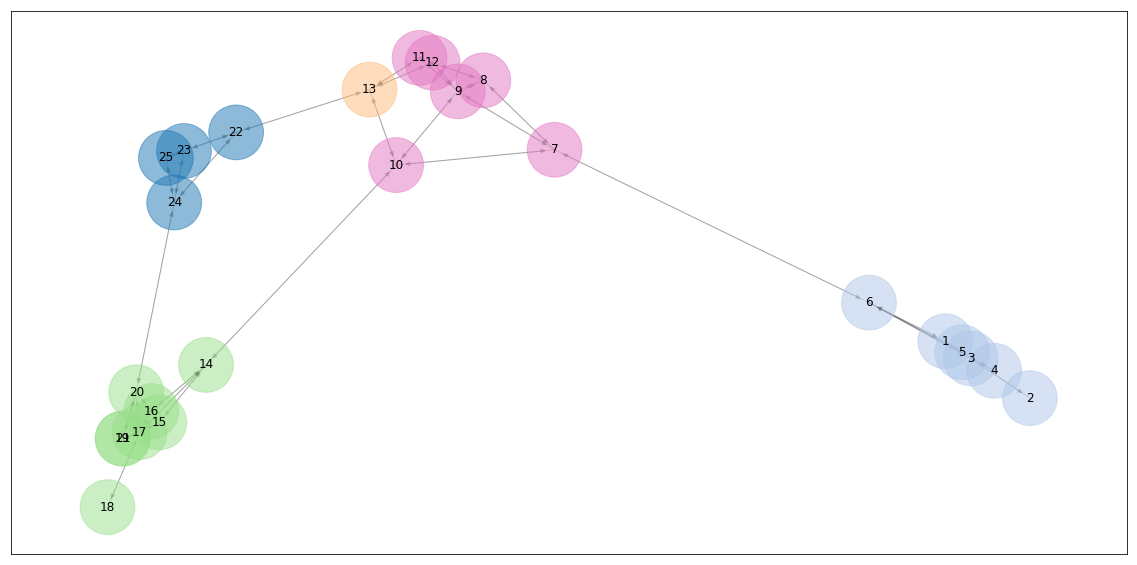

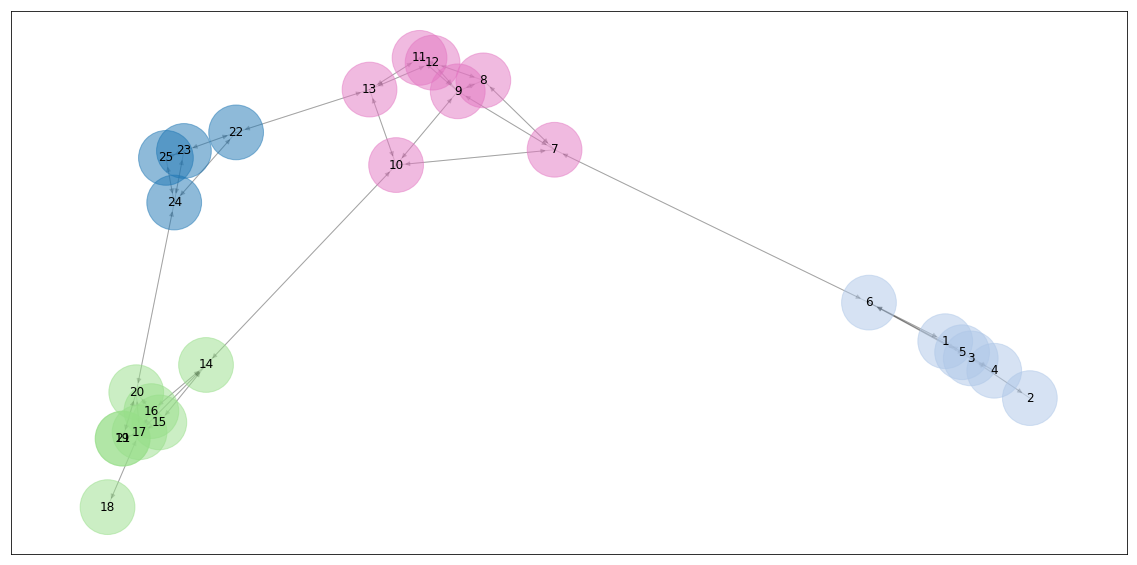

In [10]:
for i in range(2,22):
    plotGraph( infoflow_config['log']["Full Json path"], i )

### So in the end, it took 21 merges to merge a graph of 25 nodes into 4 communities. The complexity is linear to the number of nodes

Can we do better? In InfoFlow, in each iteration, rather than merging a pair of communities, each community seeks to merge with another, and the weakly connected components of these communities all merge into one. If we postulate that during each iteration, a roughly constant number $k$ of modules merge into one, then the number of iterations would be ${log}_kn$, $n$ being the number of nodes. Thus, the time complexity would be logarithmic to the number of nodes, presenting a substantial performance increase

## Now, set up and run InfoFlow

In [11]:
def runInfoFlow( java_conf, infoflow_config ):
    """Set up config file and runs InfoFlow"""

    infoflow_config_string = json.dumps( infoflow_config, indent=2 )
    notebook_json = "notebook.json"
    with open(notebook_json,"w") as config_handle:
        config_handle.write(infoflow_config_string)

    jar = "{}_{}-{}.jar".format( java_conf['jar_name'], java_conf['scala_version'], java_conf['infoflow_version'] )
    return os.system("spark-submit target/scala-{}/{} {}".format( java_conf['scala_version'], jar, "notebook.json" ))
infoflow_config['Community Detection']['name'] = 'InfoFlow'
runInfoFlow( java_conf, infoflow_config )

0

## See? Only 2 merges required to arrive at identical result!

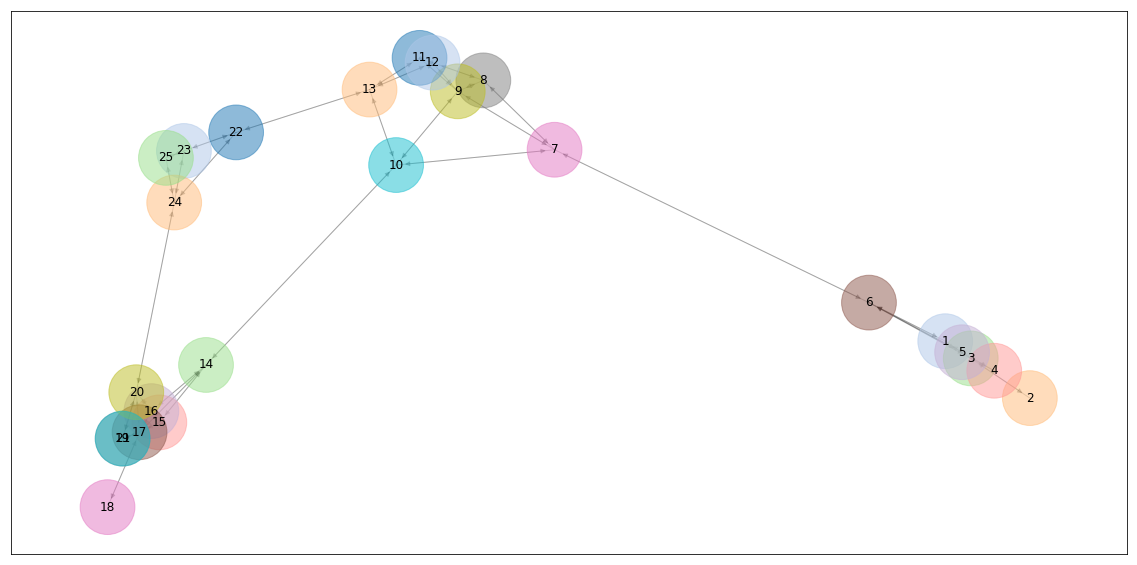

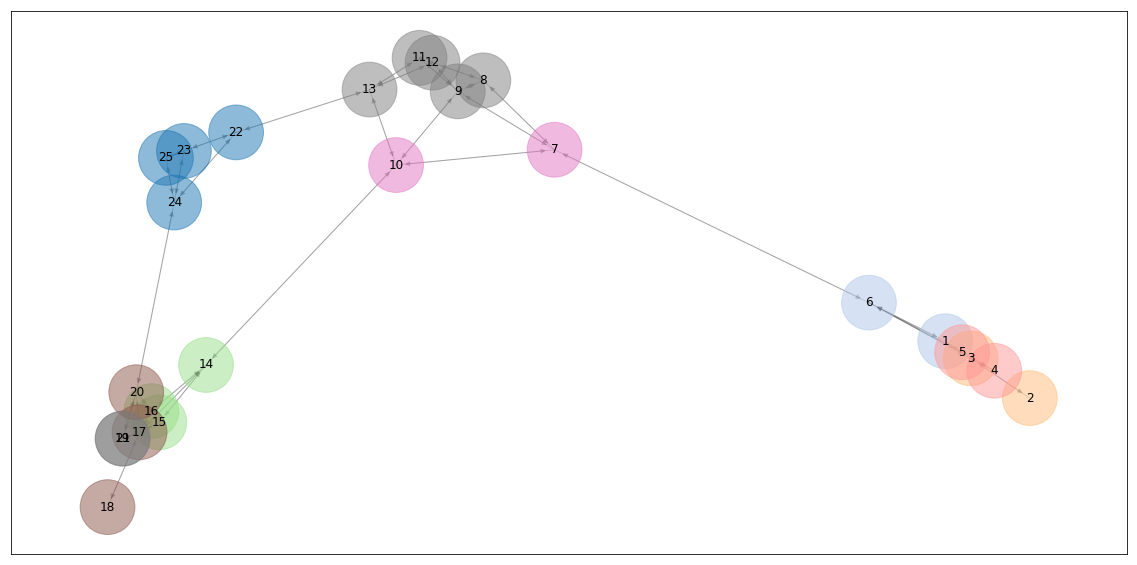

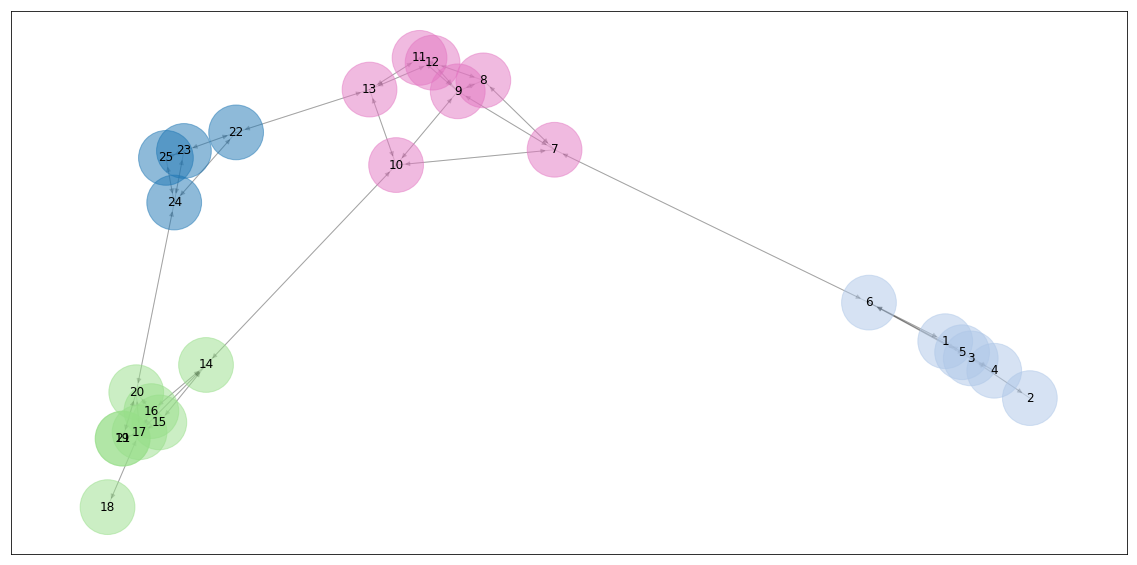

In [12]:
for i in range(0,3):
    plotGraph( infoflow_config['log']["Full Json path"], i )

## So how is the computation done?

The InfoMap algorithm is about minimizing the entropy, which we merge modules greedily as visualized above. Importantly, the entropy calculation can be shown to depend two terms: a constant term that does not depend on modular partitioning, and one that depends only on the graph's modular properties. Thus, after calculating and remembering the constant term, for the purpose of entropy calculation, (also, if we only care about a reduced graph where each node is a community) we can forget about the original nodes. This allows economic adaptation of the variables into Spark RDD, where each element of the RDD contains the modular properties of one module.

For the complete mathematical derivation, see `InfoFlow Maths.pdf`.